In [2]:
import pandas as pd, numpy as np
import seaborn as sns
import torch
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from skimage.color import rgb2gray
from skimage.filters import sobel, scharr, apply_hysteresis_threshold, gaussian
from skimage.feature import canny
from skimage.measure import regionprops,regionprops_table
from skimage.morphology import binary_opening, disk, binary_closing, binary_dilation, binary_erosion
from skimage.draw import rectangle_perimeter
from sklearn.model_selection import train_test_split
from scipy.ndimage import label as scilabel
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300
# make sure pytorch is installed
# see this tutorial: https://github.com/jlevy44/medstudent_resident_informatics_tutorials/blob/main/1_image_analysis/1_image_analysis.ipynb

# Load cell data

In [3]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

In [4]:
urothelial_cells.keys()

dict_keys(['X', 'y'])

In [5]:
# Change the value of idx_image as the index to showcase different images.
idx_image=2
img=images[idx_image]

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

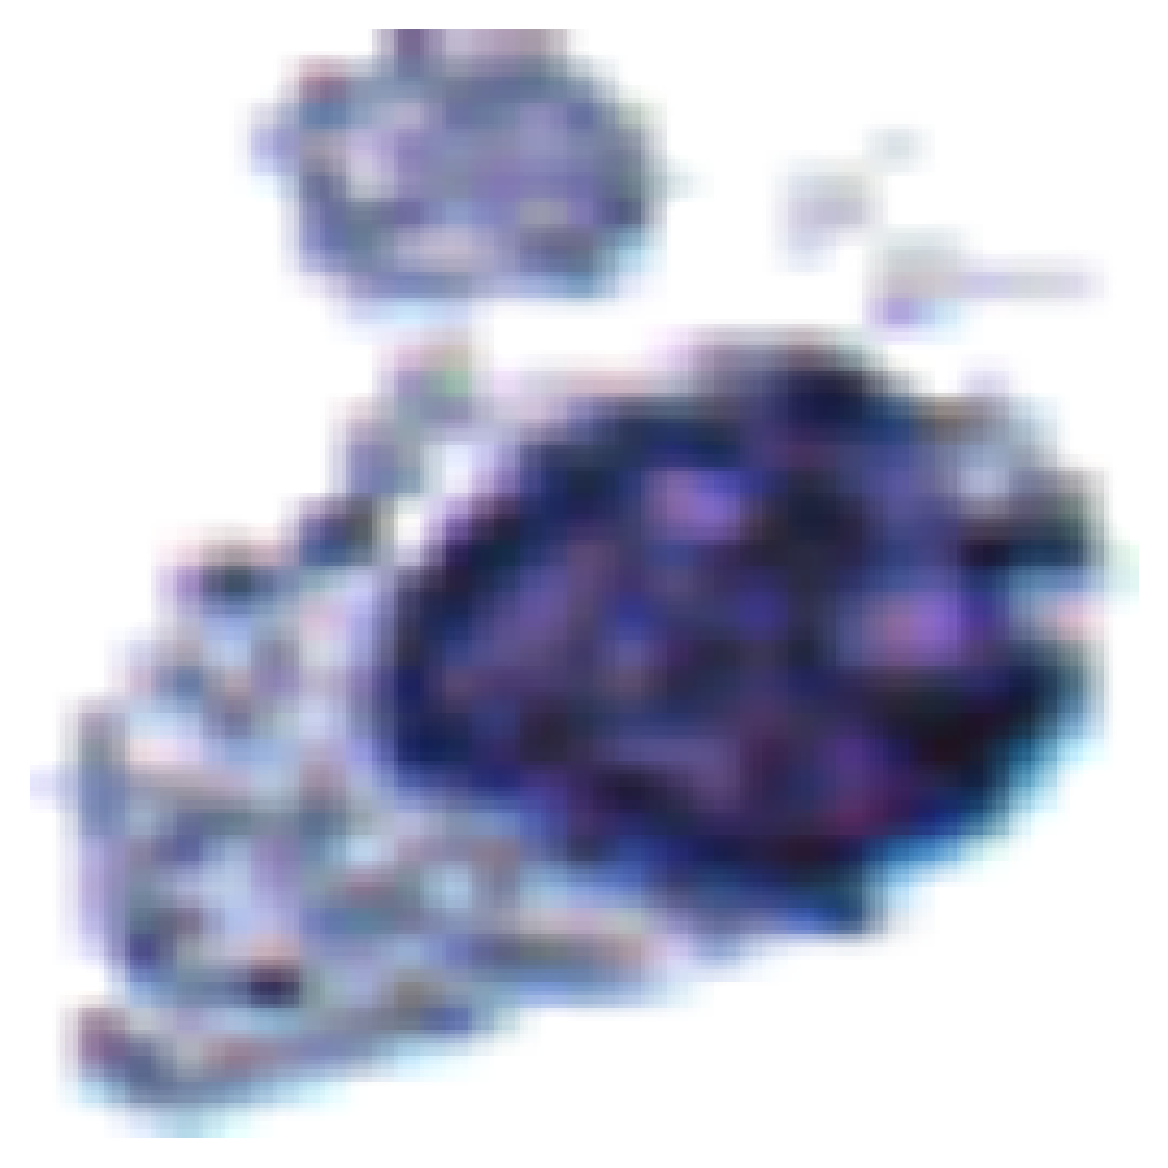

In [7]:
# Display the target image
plt.imshow(img)
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

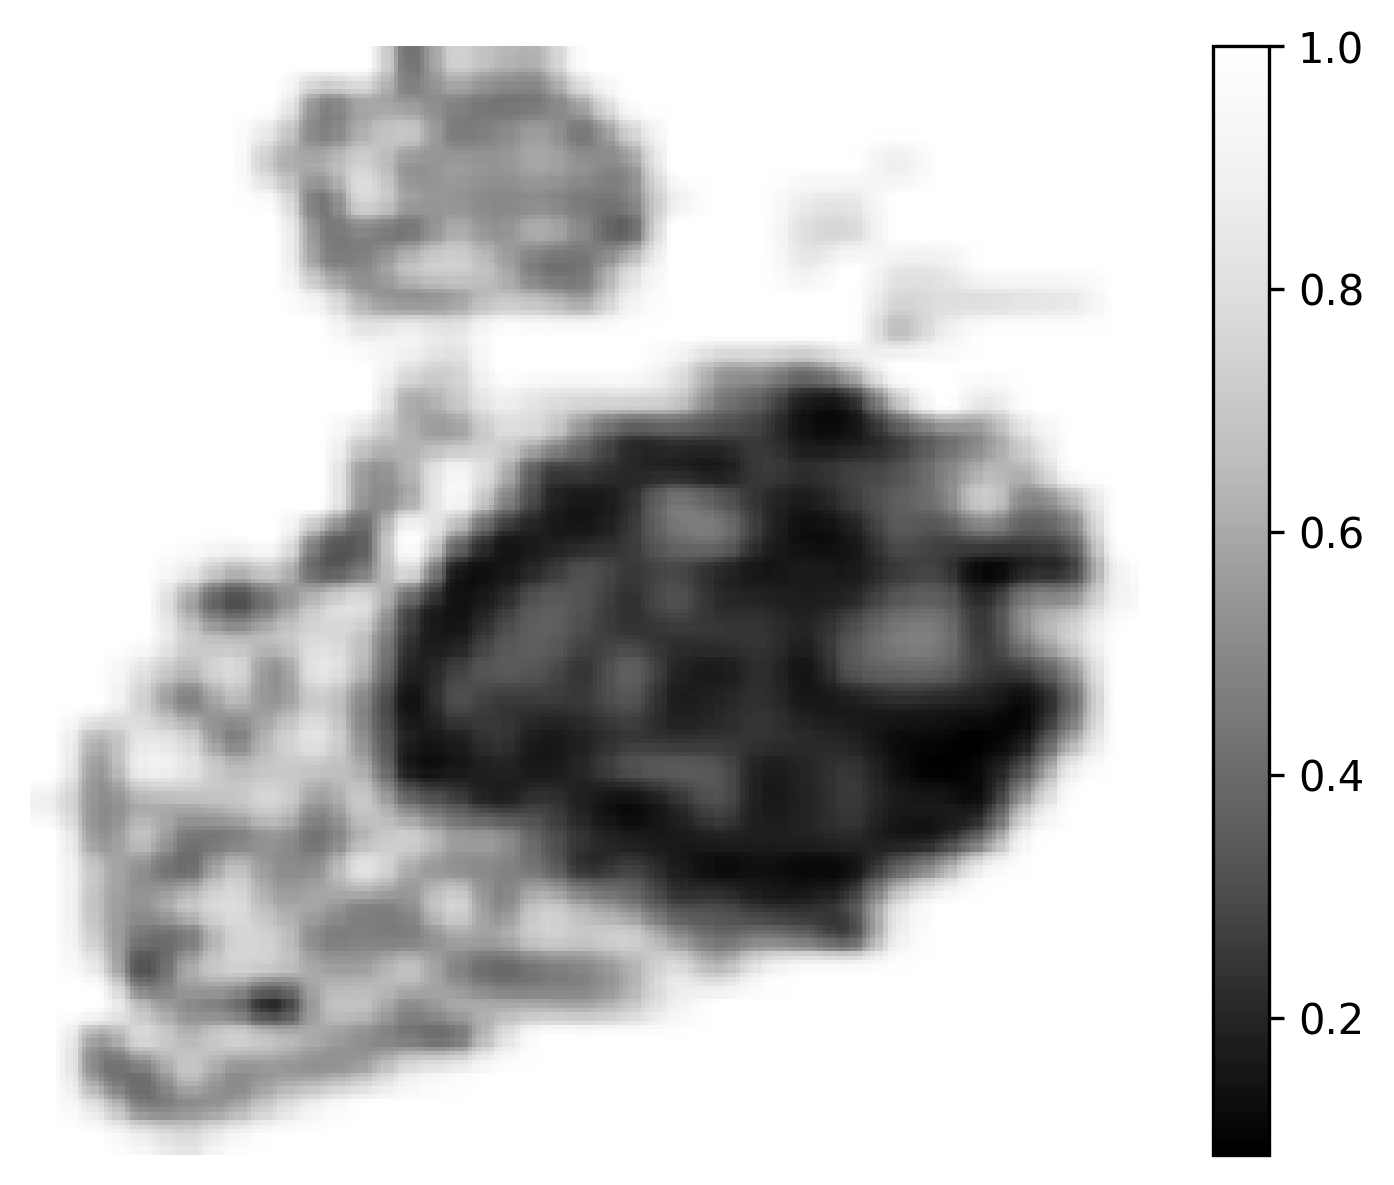

In [ ]:

# Converted into a grayscale image and display
img_gray=rgb2gray(img)
plt.imshow(img_gray,cmap="Greys_r")
plt.colorbar()
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

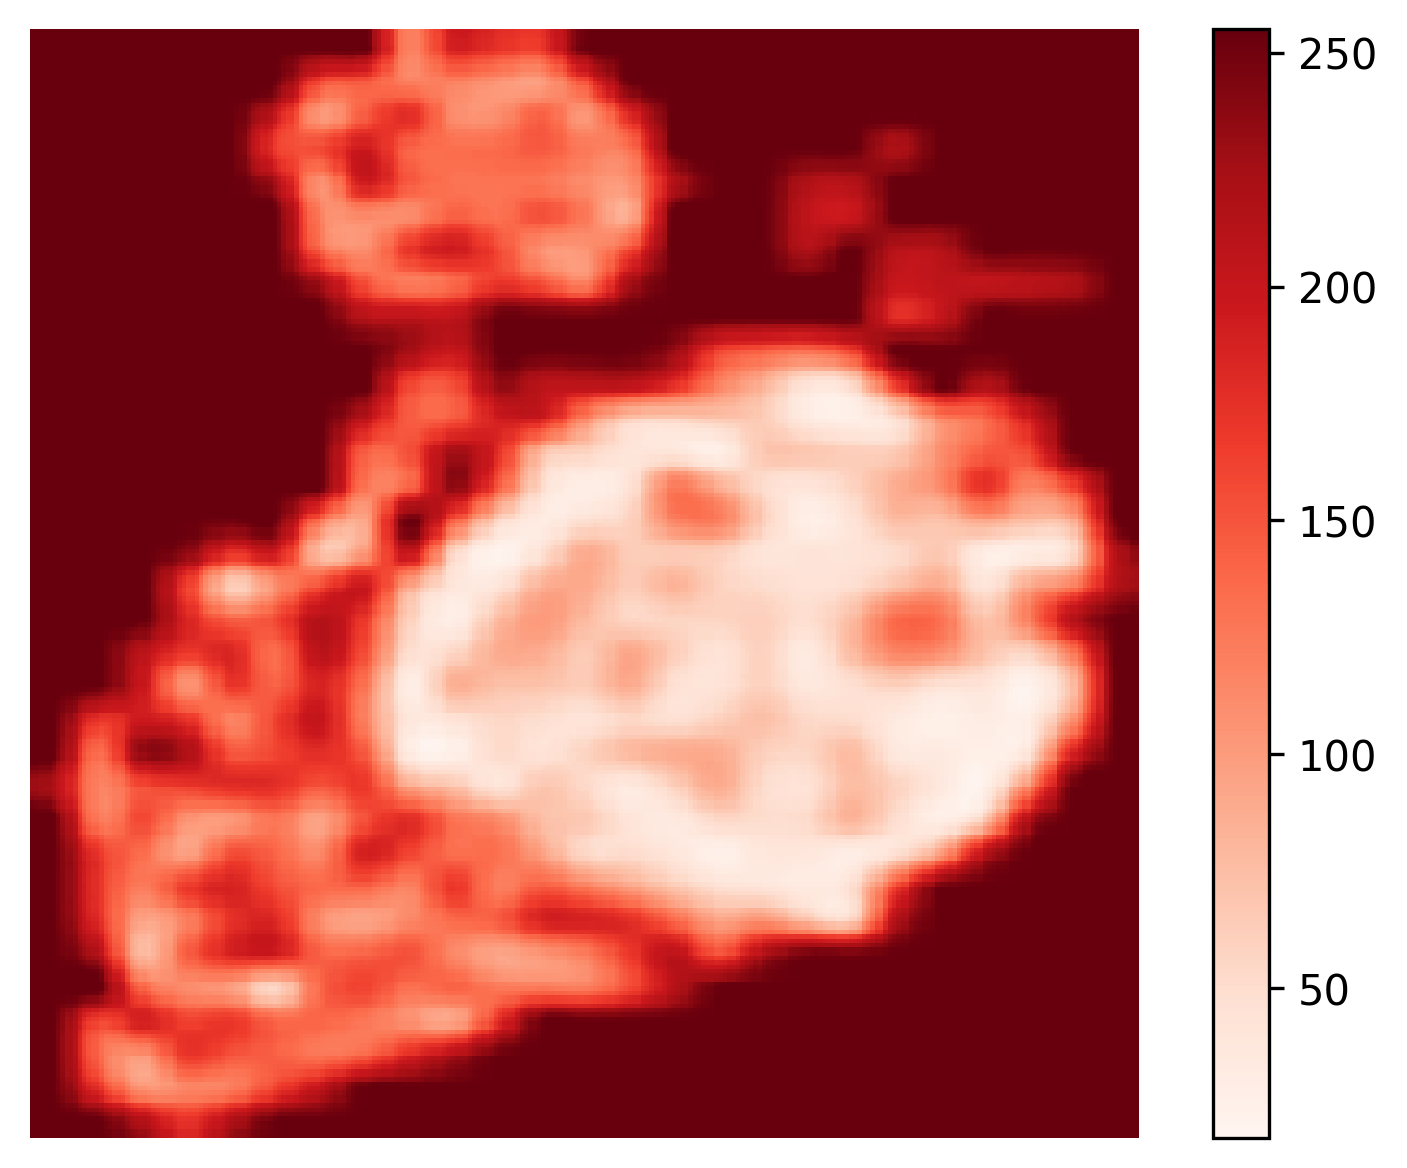

In [ ]:
# Display the red channel only in the RGB amage
plt.imshow(img[...,0],cmap="Reds")
plt.colorbar()
plt.axis("off")

(array([ 3157.,  6698.,  3587.,  2615.,  5135.,  5772.,  4795.,  3433.,
         3192., 27152.]),
 array([0.08706941, 0.17836247, 0.26965553, 0.36094859, 0.45224165,
        0.54353471, 0.63482776, 0.72612082, 0.81741388, 0.90870694,
        1.        ]),
 <BarContainer object of 10 artists>)

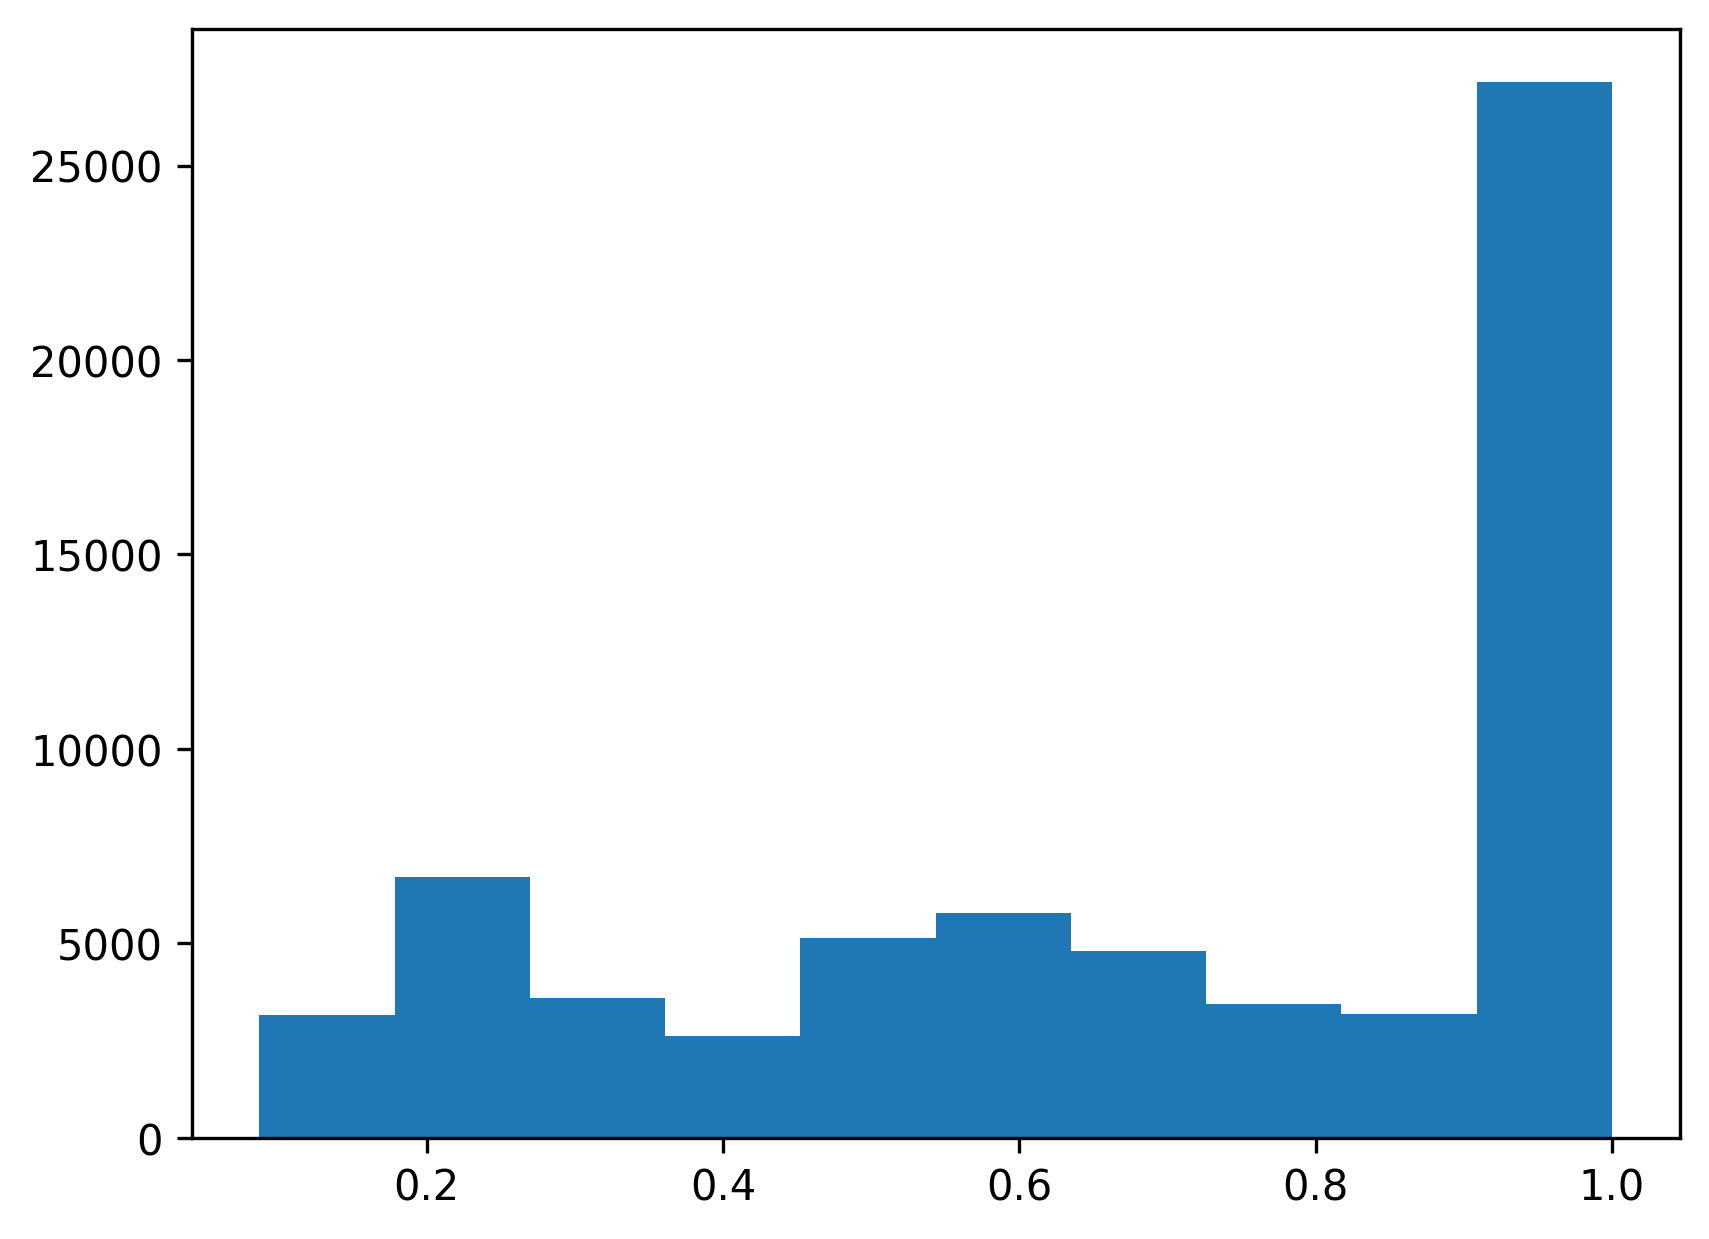

In [ ]:
# Create a histogram of the pixel intensity values in a grayscale image.
plt.hist(img_gray.flatten())

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

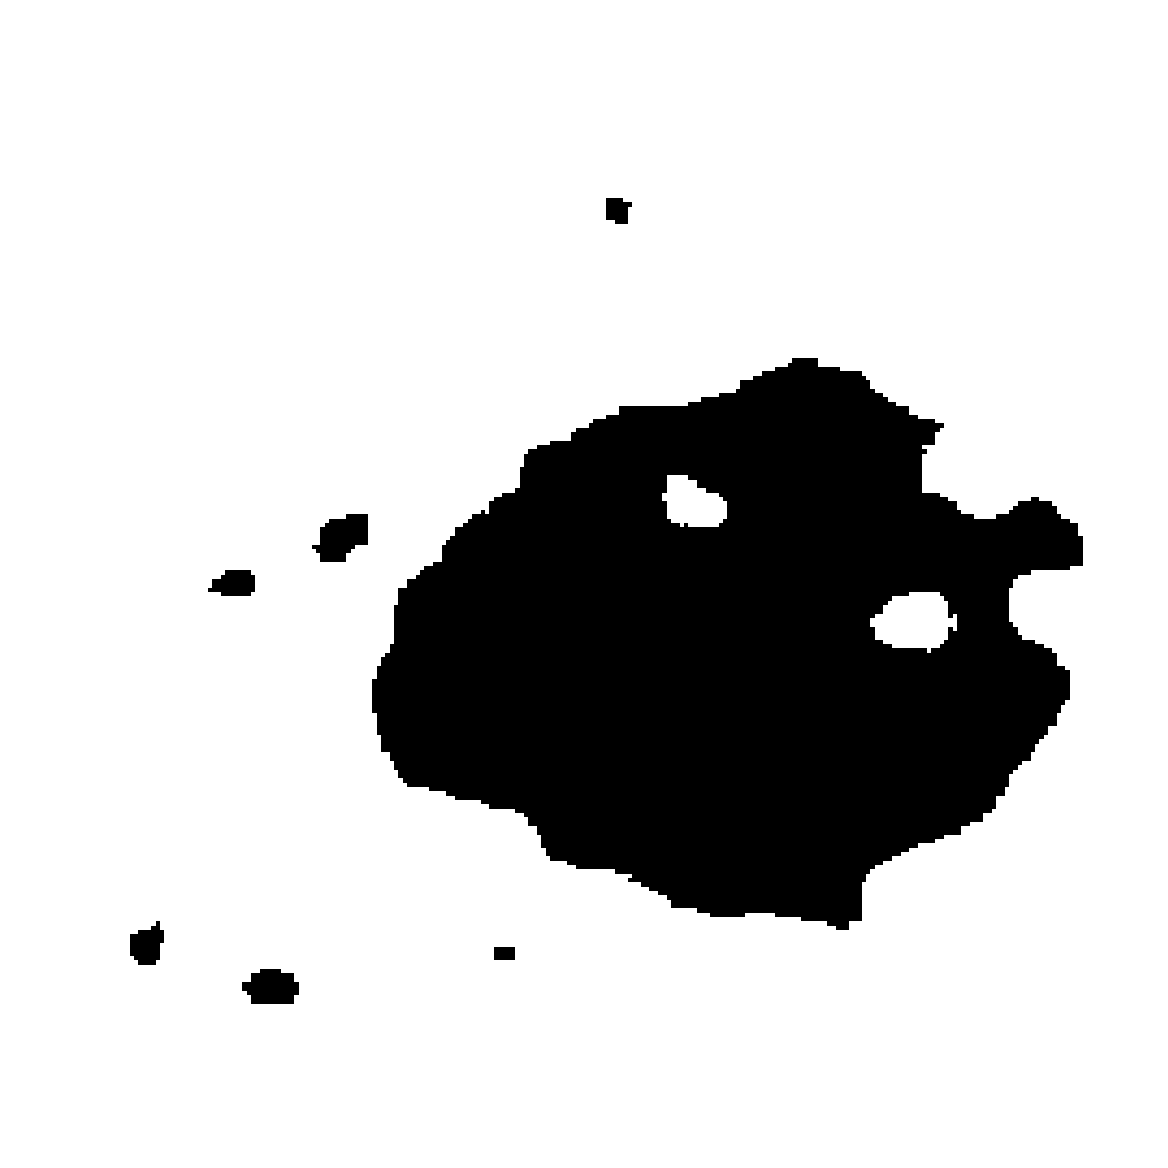

In [ ]:
# Create a binary mask using the pixels with value 0.4 in the grayscale image
nucleus=img_gray<0.4
plt.imshow(nucleus,cmap="Greys")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

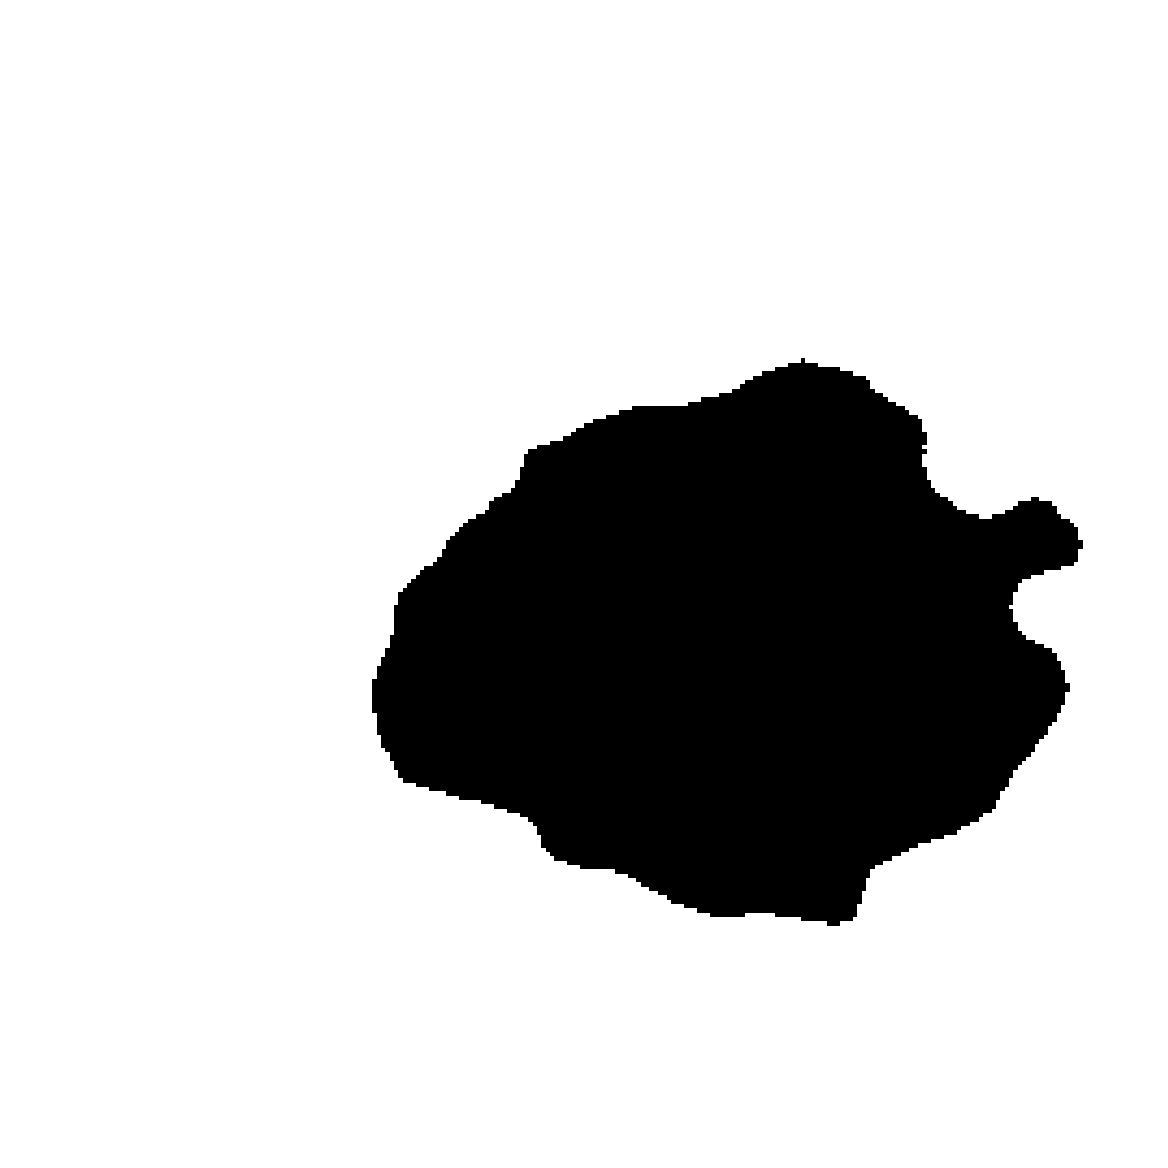

In [ ]:
# Performs image thresholding followed by morphological operations, which removes small objects (radius of 5 pixels) 
# and fills small holes(radius of 8 pixels) to clean up the binary mask
nucleus=img_gray<0.4
nucleus=binary_opening(nucleus,disk(5))
nucleus=binary_closing(nucleus,disk(8))
plt.imshow(nucleus,cmap="Greys")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

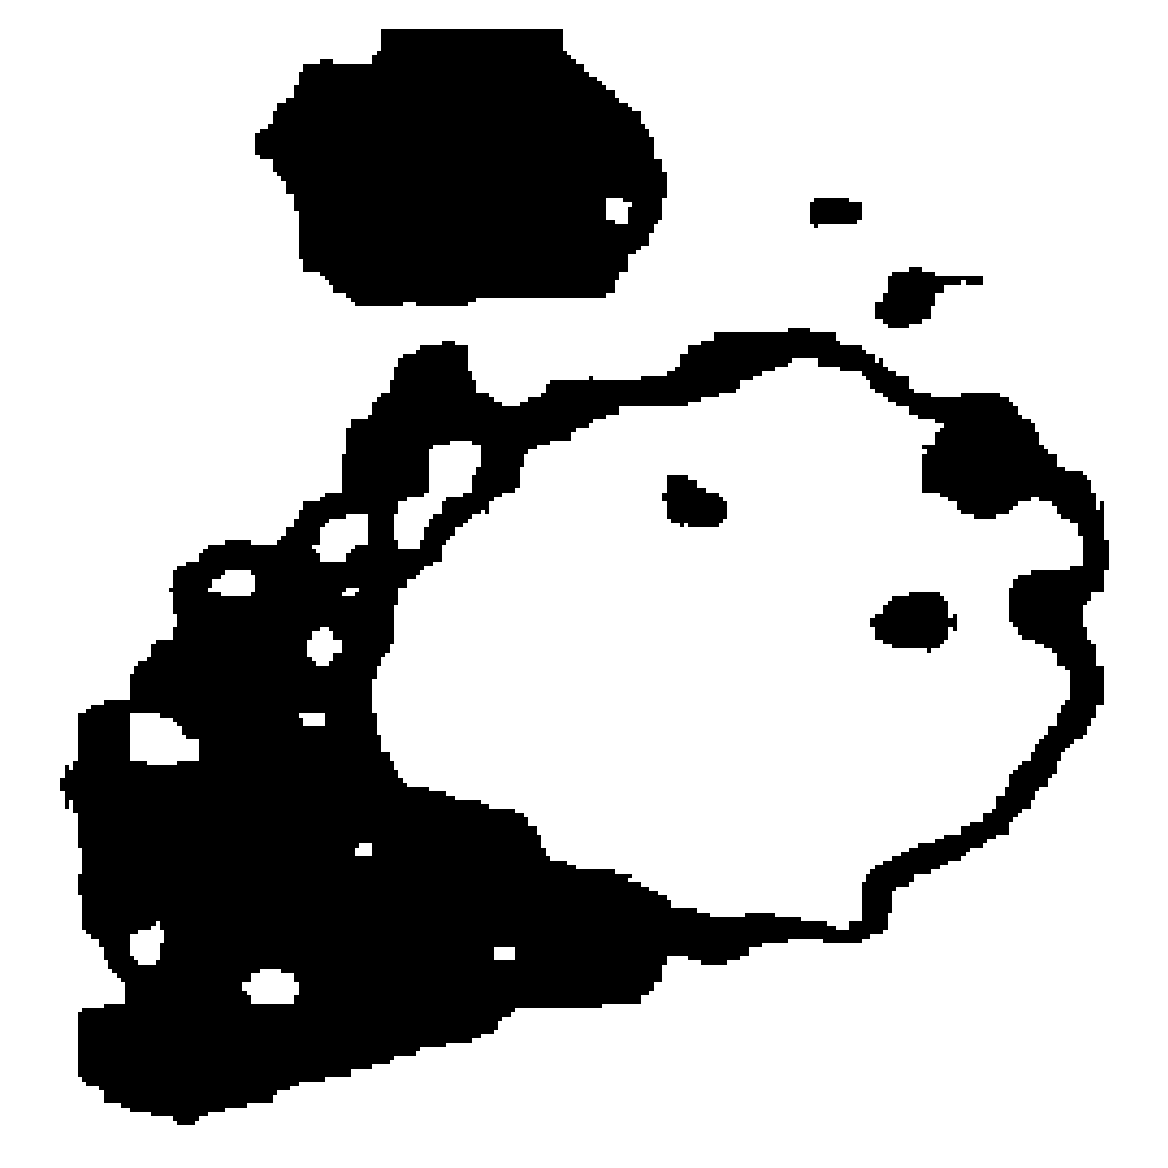

In [ ]:
# Creates a binary mask for pixels with intensity values between 0.4 and 0.8 for the cytoplasm region
cytoplasm=np.logical_and(img_gray>=0.4,img_gray<=0.8)
plt.imshow(cytoplasm,cmap="Greys")
plt.axis("off")

In [112]:
nc_ratio_pred=nucleus.sum()/(nucleus.sum()+cytoplasm.sum())


In [113]:
segmentation_mask=labels[idx_image]

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

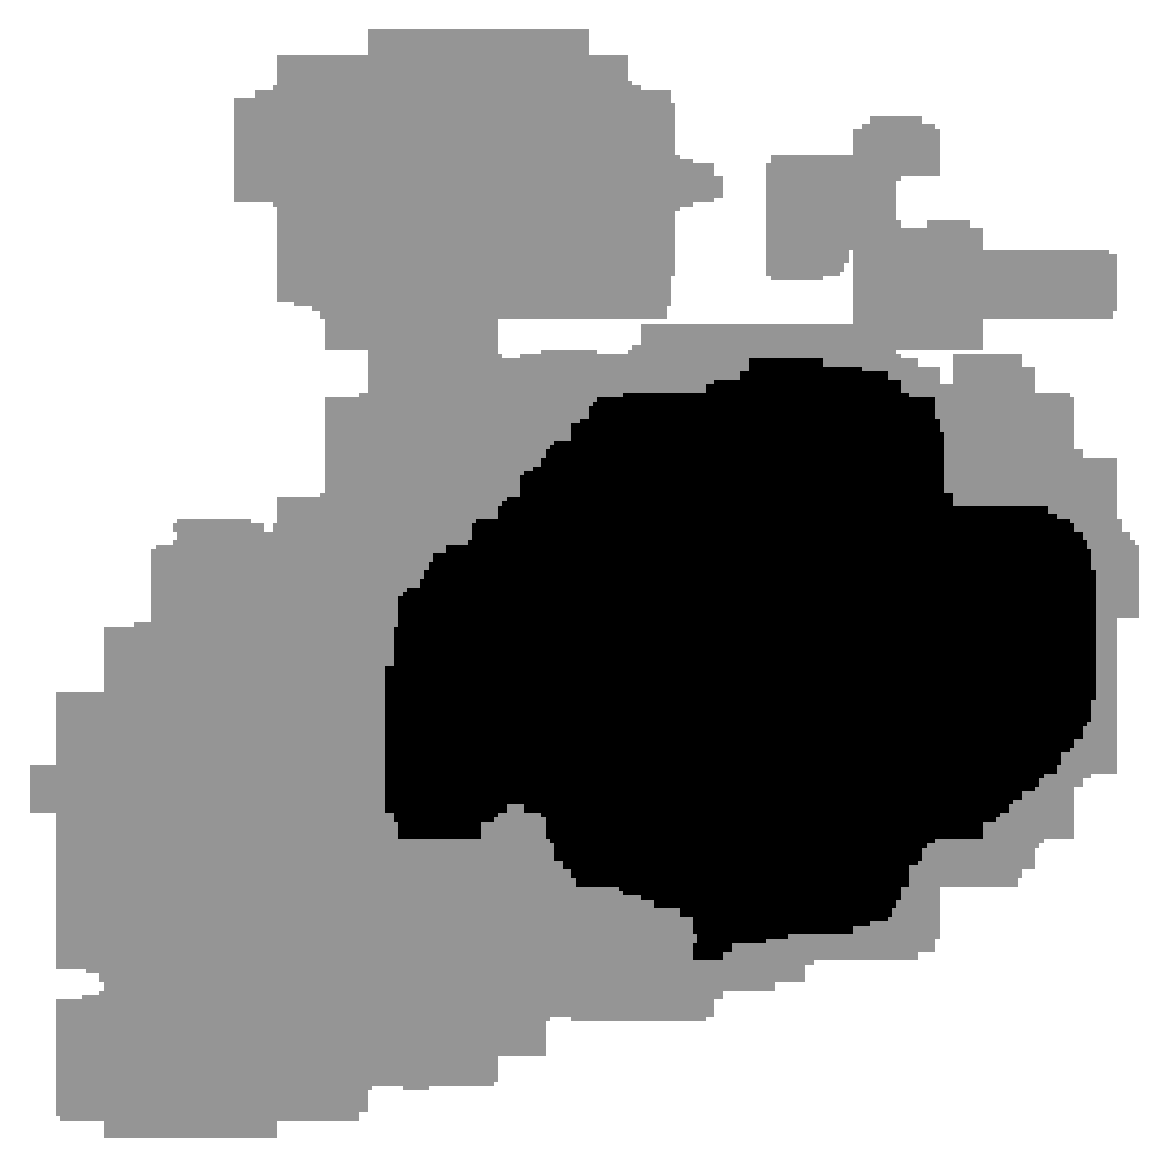

In [114]:
plt.imshow(segmentation_mask,cmap="Greys")
plt.axis("off")

In [115]:
cytoplasm_true=(segmentation_mask==1)
nucleus_true=(segmentation_mask==2)
nc_ratio_true=nucleus_true.sum()/(nucleus_true.sum()+cytoplasm_true.sum())


In [116]:
nc_ratio_true,nc_ratio_pred


(np.float64(0.3643818624523361), np.float64(0.41576448792913795))

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

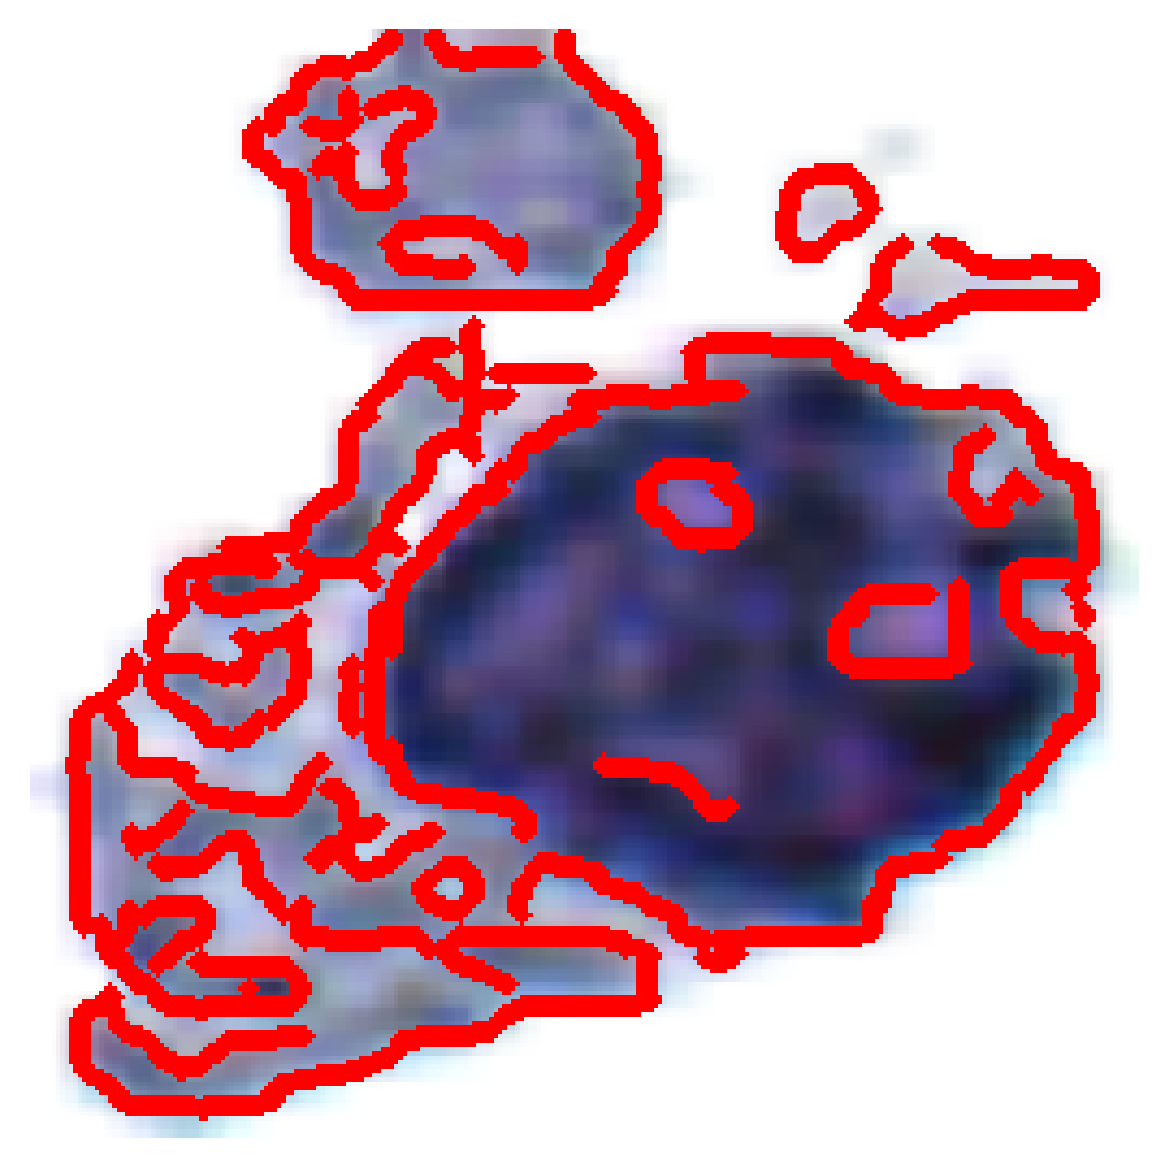

In [ ]:
# detect edges in the grayscale image and mark it in red
edges=binary_dilation(canny(img_gray, sigma=2.),disk(2))
img_new=img.copy()
img_new[edges]=[255,0,0]
plt.imshow(img_new)
plt.axis("off")

# Generate labels for deep learning analysis

In [ ]:
# Split a dataset (urothelial_cells) into training and validation sets.
# By default, train_test_split() splits the data into 75% training and 25% validation sets.
X_train,Y_train,X_val,Y_val=train_test_split(urothelial_cells["X"],torch.LongTensor(urothelial_cells["y"]),random_state=42)

In [ ]:
# model=train_model(X_train,Y_train,X_val,Y_val)
# y_val_pred=make_predictions(X_val,model=None)  # Uses the trained model to make predictions on the validation set. if None, it assumes the model is already defined or loaded.
# y_val_pred_lbls=y_val_pred.argmax(1)  # Converts the model's predictions into class labels.
# print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))  # Evaluates the model's performance by comparing the predicted labels (y_val_pred_lbls) to the true labels (Y_val).
# ...

Follow this tutorial: https://github.com/jlevy44/medstudent_resident_informatics_tutorials/blob/main/1_image_analysis/2_image_segmentation.ipynb

# Load specimens data

In [ ]:
# Specimen Cell Dataset: Contains 25 cells per patient, with patients categorized by diagnosis. 
# The aim is to study the predictive power of the developed biomarker (N/C ratio) and its distribution across different patient diagnoses.
sps=pd.read_pickle("specimens_toy_data.pkl")

In [ ]:
# Combine metadata from multiple categories in the sps dataset into a single DataFrame (df).
# "neg","aty","sus","pos": Negative, Atypical, Suspicious, Positive
df=pd.concat([sps[k]["metadata"].assign(class_=lambda x: k) for k in sps])
df["class_"]=pd.Categorical(df["class_"],["neg","aty","sus","pos"])
    # ["nc_ratio"]

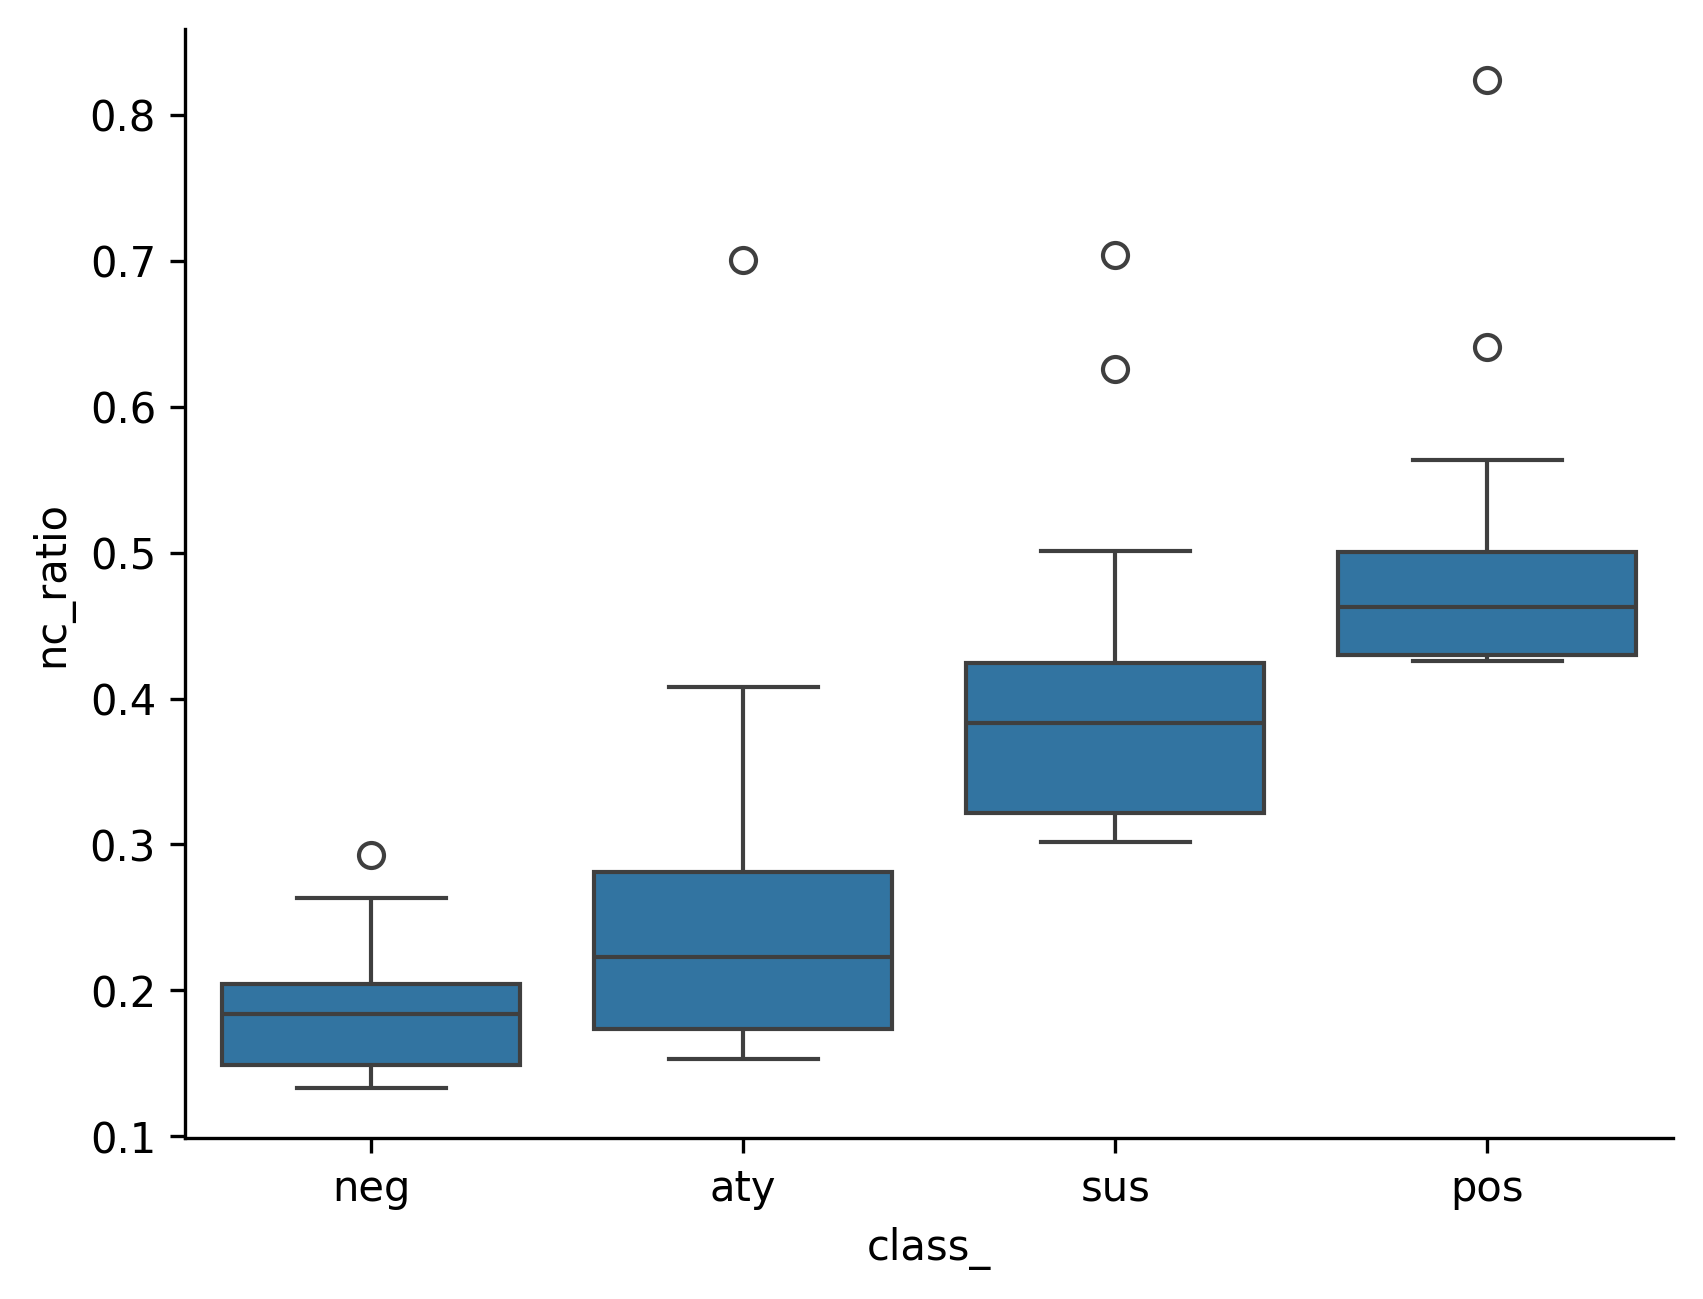

In [ ]:
# create a boxplot to visualize the distribution of the Nucleus-to-Cytoplasm (N/C) ratio (nc_ratio) across different diagnostic categories (class_).
# Boxplot contains five-number summary: Minimum, Maximum, Median, First quartile, Third quartile.
sns.boxplot(x="class_",y="nc_ratio",data=df)
sns.despine()

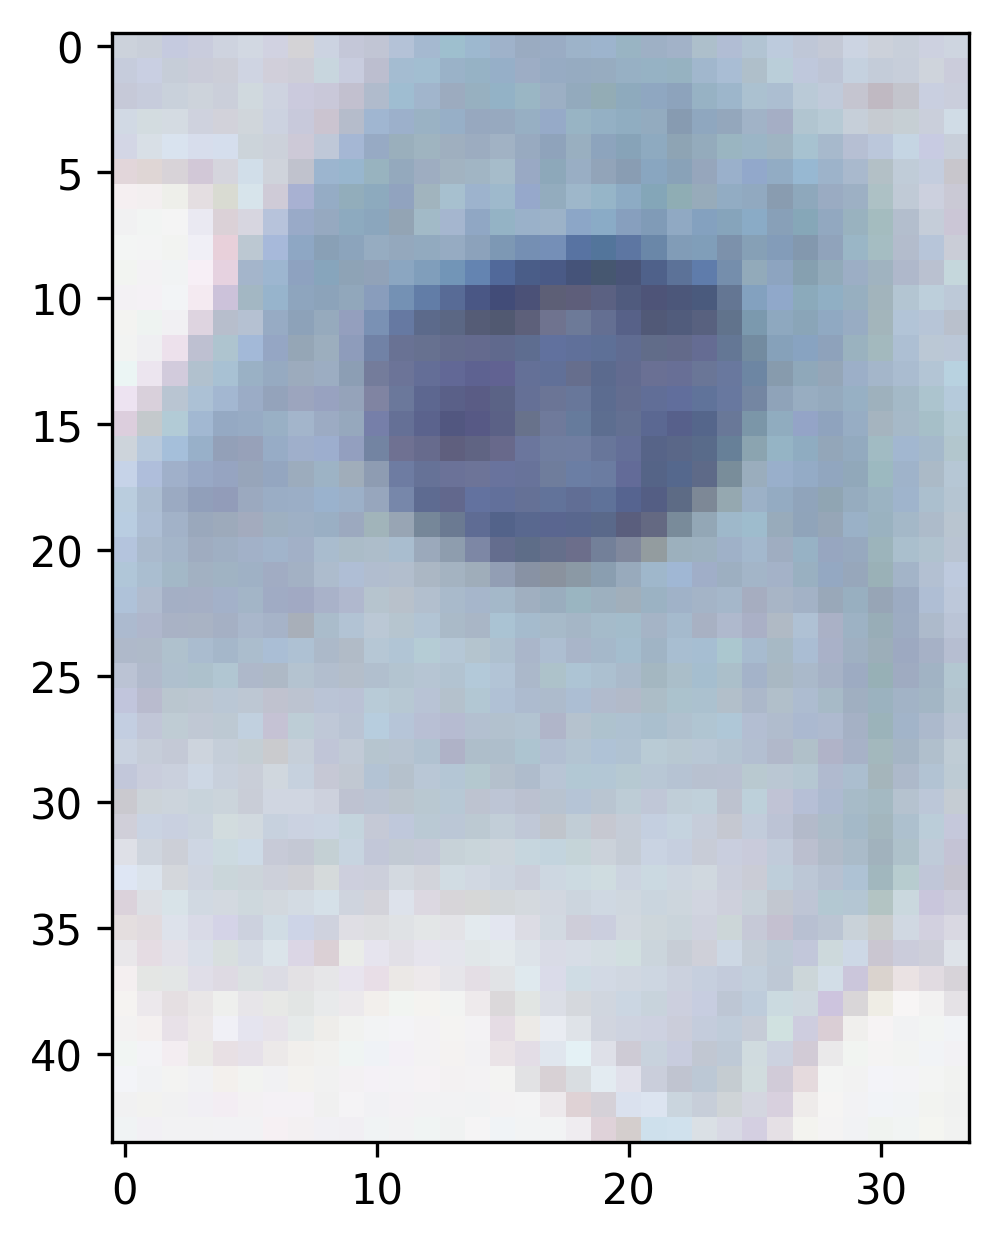

In [141]:
plt.imshow(sps["neg"]["imgs"][0])

In [140]:
from functools import reduce
resize = lambda x: cv2.resize(x,(256,256),interpolation=cv2.INTER_CUBIC)
all_images=reduce(lambda x,y: x+y,[list(map(resize,sps[k]["imgs"])) for k in sps])

In [137]:
# describes above images, assess performance for NC ratio, class assignment, etc
df.head()

,aty,nc_ratio,nuclear_area,cyto_area,class_
0,0.057022,0.141928,7221.0,43657.0,neg
1,0.037513,0.175625,7597.0,35660.0,neg
2,0.056971,0.150782,7442.0,41914.0,neg
3,0.077020,0.182437,8177.0,36644.0,neg
4,0.111039,0.183712,8696.0,38639.0,neg
